In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Resize
import torchvision
import matplotlib.pyplot as plt
from transformers import CLIPModel, CLIPProcessor

In [2]:
#Define device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Load the pre-trained CLIP model in Pytorch

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# NUmber of Parameters

print(f"Number of parameters: {model.num_parameters()}")


Number of parameters: 149620737


/home/diego/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# Load the CIFAR-10 dataset 

transform = Compose([
    Resize((224, 224)),  # Redimensiona las imágenes a 224x224 píxeles
    ToTensor(),
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


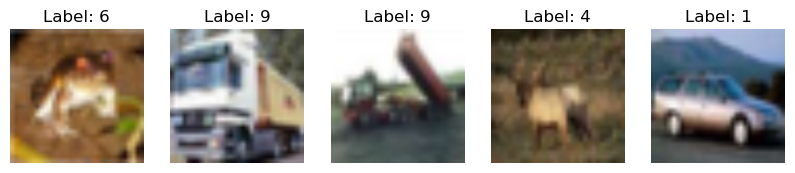

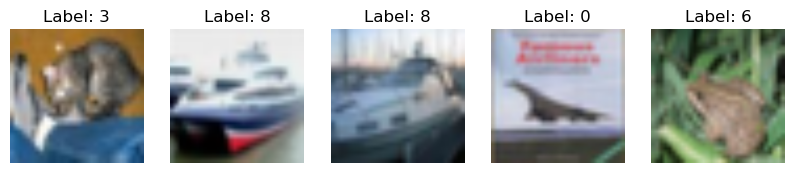

In [5]:
#Visualize 5 examples with their class labels from the train split and test split

def show_images(dataset):
    figure = plt.figure(figsize=(10, 5))
    for i in range(5):
        img, label = dataset[i]
        figure.add_subplot(1, 5, i+1)
        plt.title(f"Label: {label}")
        plt.axis("off")
        plt.imshow(torchvision.utils.make_grid(img).permute(1, 2, 0))
    plt.show()

show_images(train_dataset)
show_images(test_dataset)

In [6]:
#Freeze the CLIP model a

for param in model.parameters():
    param.requires_grad = False

#Two layer neural network

class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x
    
classifier = SimpleClassifier(input_dim=512, hidden_dim=256, output_dim=10).to(device)

In [7]:
#Preparing training and test data

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

def get_embeddings(dataloader, model, processor):
    embeddings = []
    labels = []
    model.eval()
    
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs = processor(images=inputs, return_tensors="pt").pixel_values.to(device)
            outputs = model.get_image_features(inputs).to(device)
            embeddings.append(outputs)
            labels.append(targets)
    
    return torch.cat(embeddings), torch.cat(labels)

# Obtain embeddings for training and test
train_embeddings, train_labels = get_embeddings(train_loader, model, processor)
test_embeddings, test_labels = get_embeddings(test_loader, model, processor)


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [8]:
#we must move everything to the device
train_embeddings = train_embeddings.to(device)
train_labels = train_labels.to(device)
test_embeddings = test_embeddings.to(device)
test_labels = test_labels.to(device)

In [9]:
#Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

In [10]:
# Function to train the model
def train_classifier(epochs, train_embeddings, train_labels, criterion, optimizer):
    classifier.train()  # We set the classifier to training mode
    for epoch in range(epochs):
        optimizer.zero_grad()  # Reset gradients
        outputs = classifier(train_embeddings)  # We pass the embeddings through the classifier
        loss = criterion(outputs, train_labels)  # We calculate the loss
        loss.backward()  # We calculate the gradients
        optimizer.step()  # We update the classifier parameters
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


In [14]:
#Training the model
train_classifier(epochs=40000, train_embeddings=train_embeddings, train_labels=train_labels, 
                 criterion=criterion, optimizer=optimizer)

Epoch 1/40000, Loss: 1.2257851362228394
Epoch 2/40000, Loss: 1.2303105592727661
Epoch 3/40000, Loss: 1.2351043224334717
Epoch 4/40000, Loss: 1.2403250932693481
Epoch 5/40000, Loss: 1.2453688383102417
Epoch 6/40000, Loss: 1.244797706604004
Epoch 7/40000, Loss: 1.2392871379852295
Epoch 8/40000, Loss: 1.2283297777175903
Epoch 9/40000, Loss: 1.22085440158844
Epoch 10/40000, Loss: 1.220906376838684
Epoch 11/40000, Loss: 1.2262731790542603
Epoch 12/40000, Loss: 1.2330650091171265
Epoch 13/40000, Loss: 1.2370789051055908
Epoch 14/40000, Loss: 1.2419788837432861
Epoch 15/40000, Loss: 1.2389318943023682
Epoch 16/40000, Loss: 1.2363991737365723
Epoch 17/40000, Loss: 1.231950044631958
Epoch 18/40000, Loss: 1.2271504402160645
Epoch 19/40000, Loss: 1.2243621349334717
Epoch 20/40000, Loss: 1.2248252630233765
Epoch 21/40000, Loss: 1.2277358770370483
Epoch 22/40000, Loss: 1.2295489311218262
Epoch 23/40000, Loss: 1.2328013181686401
Epoch 24/40000, Loss: 1.2332388162612915
Epoch 25/40000, Loss: 1.235336

In [13]:
# Function to evaluate accuracy
def evaluate_classifier(test_embeddings, test_labels):
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        outputs = classifier(test_embeddings)
        _, predicted = torch.max(outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Evaluate accuracy of training and test predictions
train_accuracy = evaluate_classifier(train_embeddings, train_labels)
test_accuracy = evaluate_classifier(test_embeddings, test_labels)

print(f'Accuracy in training: {train_accuracy:.2f}%')
print(f'Test accuracy: {test_accuracy:.2f}%')


Precisión en entrenamiento: 56.18%
Precisión en prueba: 54.60%
